🚀 Starting ETL…

Extracting source data…


C:\Users\Admin\AppData\Local\Temp\ipykernel_336\2961684454.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  patients = pd.read_sql("SELECT * FROM patient_records", p_conn)
C:\Users\Admin\AppData\Local\Temp\ipykernel_336\2961684454.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  billing  = pd.read_sql("SELECT * FROM hospital_billing", b_conn)
C:\Users\Admin\AppData\Local\Temp\ipykernel_336\2961684454.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  meds     = pd.read_sql("SELECT * FROM pharmacy_inventory", ph_co

Done extracting.

Transforming data…
Done transforming.

Loading into Data Warehouse…
Load complete!

Predicting next 6 months for 'Flu'…

Forecast:
  2025-05: 9449 cases
  2025-06: 1636 cases
  2025-07: 0 cases
  2025-08: 0 cases
  2025-09: 0 cases
  2025-10: 0 cases


C:\Users\Admin\AppData\Local\Temp\ipykernel_336\2961684454.py:166: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, params=(disease_name,))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


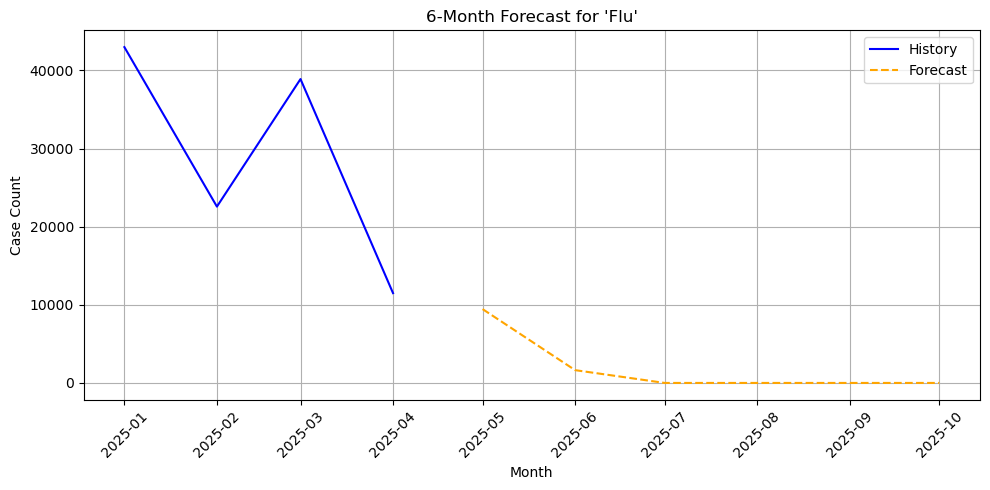

In [1]:
import pandas as pd
import mysql.connector
from datetime import datetime
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# DATABASE SETTINGS 
SOURCE_DB = {
    'host': 'localhost',
    'user': 'root',
    'password': 'sher123'
}

WAREHOUSE_DB = {
    'host': 'localhost',
    'user': 'root',
    'password': 'sher123',
    'database': 'DataWareHouse'
}


def extract_data():
    """Get raw tables from source systems and public CSV"""
    print("Extracting source data…")
    p_conn = mysql.connector.connect(**SOURCE_DB, database='patient')
    b_conn = mysql.connector.connect(**SOURCE_DB, database='hospital_billing_system')
    ph_conn = mysql.connector.connect(**SOURCE_DB, database='pharmacy_inventory_system')

    patients = pd.read_sql("SELECT * FROM patient_records", p_conn)
    billing  = pd.read_sql("SELECT * FROM hospital_billing", b_conn)
    meds     = pd.read_sql("SELECT * FROM pharmacy_inventory", ph_conn)
    public   = pd.read_csv("External_Public_Health_Data.csv")

    p_conn.close(); b_conn.close(); ph_conn.close()
    print("Done extracting.\n")
    return patients, billing, meds, public


def transform_data(patients, billing, meds, public):
    """Clean dates, fill gaps, normalize columns"""
    print("Transforming data…")
    billing['billing_date'] = pd.to_datetime(billing['billing_date'], errors='coerce')
    meds   ['dispensing_date'] = pd.to_datetime(meds   ['dispensing_date'], errors='coerce')
    public ['month'] = pd.to_datetime(public['month'], format='%Y-%m', errors='coerce')
    public ['cases'] = public['cases'].fillna(0).astype(int)

    # Fill missing costs
    for col in ['procedure_cost', 'medication_cost', 'insurance_claim']:
        billing[col] = billing[col].fillna(0)

    # Default patient info
    patients['birth_date'] = pd.to_datetime('1990-01-01')
    patients['address']    = 'Unknown'

    print("Done transforming.\n")
    return patients, billing, meds, public


def load_data(patients, billing, meds, public):
    """Push everything into the warehouse star schema"""
    print("Loading into Data Warehouse…")
    conn = mysql.connector.connect(**WAREHOUSE_DB)
    cur  = conn.cursor()

    # 1) Date dimension for 2025
    dates = pd.date_range('2025-01-01', '2025-12-31')
    for i, d in enumerate(dates, start=1):
        cur.execute("""
            INSERT IGNORE INTO Dim_Date
              (date_sk, full_date, day, month, year, weekday)
            VALUES (%s, %s, %s, %s, %s, %s)
        """, (i, d.date(), d.day, d.month, d.year, d.day_name()))

    # 2) Patients
    for _, r in patients.iterrows():
        cur.execute("""
            INSERT INTO Dim_Patient
            (patient_id, name, gender, birth_date, address, start_date, is_current)
            VALUES (%s, %s, %s, %s, %s, CURDATE(), 1)
        """, (r['patient_id'], r['name'], r['gender'], r['birth_date'], r['address']))

    # 3) Visits & Billing facts
    for _, r in billing.iterrows():
        pid = r['patient_id']
        bdate = r['billing_date'].date() if pd.notnull(r['billing_date']) else datetime(2025,1,1).date()
        # Visits
        diag = r.get('diagnosis_code') or 'D001'
        cur.execute("""
            INSERT INTO Fact_Visits
              (patient_sk, date_sk, diagnosis_sk, treatment, hospital_id)
            VALUES (
              (SELECT patient_sk FROM Dim_Patient WHERE patient_id=%s LIMIT 1),
              (SELECT date_sk    FROM Dim_Date    WHERE full_date=%s LIMIT 1),
              (SELECT diagnosis_sk FROM Dim_Diagnosis WHERE diagnosis_code=%s LIMIT 1),
              %s, %s
            )
        """, (pid, bdate, diag, "Paracetamol + Rest", "HSP-001"))

        # Billing
        cur.execute("""
            INSERT INTO Fact_Billing
              (patient_sk, date_sk, procedure_cost, medication_cost, insurance_claim)
            VALUES (
              (SELECT patient_sk FROM Dim_Patient WHERE patient_id=%s LIMIT 1),
              (SELECT date_sk    FROM Dim_Date    WHERE full_date=%s LIMIT 1),
              %s, %s, %s
            )
        """, (pid, bdate, r['procedure_cost'], r['medication_cost'], r['insurance_claim']))

    # 4) Medications & prescriptions
    for _, r in meds.iterrows():
        # Add medication
        cur.execute("""
            INSERT IGNORE INTO Dim_Medication
              (medication_code, name, supplier, category)
            VALUES (%s, %s, %s, %s)
        """, (r['medication_code'], r['medication_name'], r['supplier'], 'General'))

        ddate = r['dispensing_date'].date() if pd.notnull(r['dispensing_date']) else datetime(2025,1,1).date()
        cur.execute("""
            INSERT INTO Fact_Prescriptions
              (patient_sk, medication_sk, date_sk, quantity)
            VALUES (
              (SELECT patient_sk FROM Dim_Patient     WHERE patient_id=%s LIMIT 1),
              (SELECT medication_sk FROM Dim_Medication WHERE medication_code=%s LIMIT 1),
              (SELECT date_sk       FROM Dim_Date       WHERE full_date=%s LIMIT 1),
              %s
            )
        """, (r['dispensing_visit_id'], r['medication_code'], ddate, r['stock_level']))

    # 5) Public health cases
    for _, r in public.iterrows():
        cur.execute("""
            INSERT IGNORE INTO Dim_Location (zip_code, region_name, city_name)
            VALUES (%s, %s, %s)
        """, (r['zip_code'], 'Default Region', 'Default City'))

        pdate = r['month'].date() if pd.notnull(r['month']) else datetime(2025,1,1).date()
        cur.execute("""
            INSERT INTO Fact_Public_Health
              (date_sk, location_sk, disease_name, case_count)
            VALUES (
              (SELECT date_sk     FROM Dim_Date     WHERE full_date=%s LIMIT 1),
              (SELECT location_sk FROM Dim_Location WHERE zip_code=%s LIMIT 1),
              %s, %s
            )
        """, (pdate, r['zip_code'], r['disease'], r['cases']))

    conn.commit()
    cur.close()
    conn.close()
    print("Load complete!\n")


def predict_case_counts(disease_name='Flu'):
    """Fetch historical cases, fit a line, and plot next 6 months."""
    print(f"Predicting next 6 months for '{disease_name}'…")

    conn = mysql.connector.connect(**WAREHOUSE_DB)
    query = """
      SELECT d.full_date AS month, f.case_count
      FROM Fact_Public_Health f
      JOIN Dim_Date d ON f.date_sk = d.date_sk
      WHERE f.disease_name = %s
    """
    df = pd.read_sql(query, conn, params=(disease_name,))
    conn.close()

    # Clean and group
    df['month'] = pd.to_datetime(df['month']).dt.to_period('M').dt.to_timestamp()
    df = df.groupby('month', as_index=False)['case_count'].sum().sort_values('month')

    # Simple index for each month
    df['idx'] = range(len(df))

    # Fit a straight line
    model = LinearRegression().fit(df[['idx']], df['case_count'])

    # Build next 6 months
    last = df['month'].iloc[-1]
    future = [last + pd.DateOffset(months=i) for i in range(1, 7)]
    future_idx = [[len(df) + i - 1] for i in range(1, 7)]

    # Predict and clip at zero
    preds = model.predict(future_idx)
    preds = [max(0, int(p)) for p in preds]

    # Print forecast
    print("\nForecast:")
    for d, p in zip(future, preds):
        print(f"  {d.strftime('%Y-%m')}: {p} cases")

    # Plot it all
    plt.figure(figsize=(10, 5))
    plt.plot(df['month'], df['case_count'], label='History', color='blue')
    plt.plot(future, preds,          label='Forecast', linestyle='--', color='orange')
    plt.xlabel('Month'); plt.ylabel('Case Count')
    plt.title(f"6-Month Forecast for '{disease_name}'")
    plt.xticks(rotation=45); plt.grid(True); plt.legend()
    plt.tight_layout(); plt.show()


if __name__ == "__main__":
    # 1) ETL
    print("🚀 Starting ETL…\n")
    pts, bill, meds, pub = extract_data()
    pts, bill, meds, pub = transform_data(pts, bill, meds, pub)
    load_data(pts, bill, meds, pub)

    # 2) Prediction
    predict_case_counts('Flu')


TypeError: mysql.connector.pooling.connect() got multiple values for keyword argument 'database'